<a href="https://colab.research.google.com/github/dmunozbe/TFM_DataScience/blob/main/NB_PM2_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Concentración de partículas (PM2.5).** Indicador nº 22 de la ISO-37120:

De acuerdo con el objetivo principal del presente TFM, se han recopilado datos de la concentración de partículas (PM2.5) de Barcelona a nivel de calle facilitadas por el Ajuntament de Barcelona / Agència de Salut Pública de Barcelona (ASPB) a traves del portal [Open Data BCN](https://opendata-ajuntament.barcelona.cat/data/es/dataset/mapes-immissio-qualitat-aire).

## Carga del conjunto de datos


Cargamos en un dataframe los gpkg obtenidos desde el año 2018 hasta 2022 sobre la concentración de partículas (PM2.5)

In [33]:
# Importamos las librerias necesarias
#import requests
import os
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import geopandas as gpd
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.cm import viridis
import warnings

In [2]:
def cargar_GPKG(ruta):
    try:
        # Cargar el archivo CSV en un DataFrame de pandas
        dataframe = gpd.read_file(ruta)
        # Obtener el nombre del archivo
        nombre_archivo = os.path.basename(ruta)
        dataframe['Any'] =  nombre_archivo[:4]
        return dataframe
    except Exception as e:
        print("Error al cargar el archivo GPKG:", e)
        return None

In [3]:
# Directorio del indicador 1
directorio ='/content/drive/MyDrive/UOC/TFM/Datasets Indicadores/Básico/Medio Ambiente/Indicador_22_PM2.5'

# Lista de archivos GPKG en el directorio
archivos_gpkg = [archivo for archivo in os.listdir(directorio) if archivo.endswith('.gpkg')]

# Lista para almacenar los DataFrames de cada archivo gpkg
dfs = []

# Iterar sobre cada archivo gpkg y cargarlo en un DataFrame
for archivo in archivos_gpkg:
    ruta_archivo = os.path.join(directorio, archivo)
    df = cargar_GPKG(ruta_archivo)
    dfs.append(df)

# Concatenar todos los DataFrames en un solo DataFrame
df_final = pd.concat(dfs, ignore_index=True)

In [4]:
# Mostramos las primeras filas del dataframe
df_final.head()

,TRAM,Rang,geometry,Any,fid
0,T04719W,10-15 µg/m³,"MULTILINESTRING ((430229.789 4586585.199, 4301...",2022,NaN
1,T19941Z,15-20 µg/m³,"MULTILINESTRING ((432928.898 4584019.988, 4329...",2022,NaN
2,T18111R,10-15 µg/m³,"MULTILINESTRING ((429953.263 4588161.441, 4299...",2022,NaN
3,T03222Y,10-15 µg/m³,"MULTILINESTRING ((427949.038 4580946.043, 4279...",2022,NaN
4,T17625I,15-20 µg/m³,"MULTILINESTRING ((433950.189 4585741.214, 4338...",2022,NaN


In [5]:
# Observamos el numero y los nombres de los atributos, el numero de filas y si hay missing-values o no
df_final.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 75205 entries, 0 to 75204
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   TRAM      75205 non-null  object  
 1   Rang      75205 non-null  object  
 2   geometry  75205 non-null  geometry
 3   Any       75205 non-null  object  
 4   fid       15041 non-null  float64 
dtypes: float64(1), geometry(1), object(3)
memory usage: 2.9+ MB


El dataset se compone de un total de 9 columnas:
*   **TRAM:** Codigo del tramo de calle
*   **Rang:** Rango de valores del contaminante, en media anual [µg/m3]
*   **geometry:** Contiene tanto la geometria como los estilos de la calle
*   **Any:** Año en el que se recogieron los datos

El dataset tiene un total de 75205 filas y no contiene missing-values


Hay que decir que, la variable any, no se corresponde con ninguna columna de los datasets originales, pero se ha incluido por tal de diferenciar en el dataframe total, de que dataset provienen los datos

Otro punto a mencionar es que la variable Rang, es una variable categorica. El dataframe carece de variable continua.

Finalmente, tambien se observa que el dataframe carece de la información de distrito.

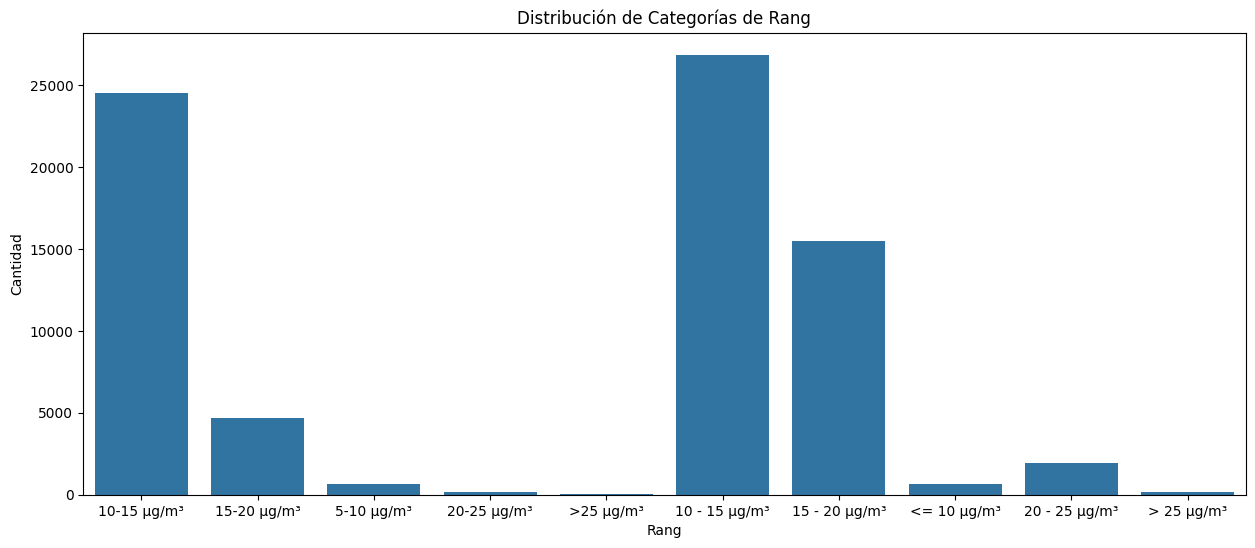

In [6]:
# Visualizamos la distribución de la variable categórica Rang utilizando un gráfico de barras
plt.figure(figsize=(15, 6))
sns.countplot(x='Rang', data=df_final)
plt.title('Distribución de Categorías de Rang')
plt.xlabel('Rang')
plt.ylabel('Cantidad')
plt.show()

Vemos que las diferentes categorias estan dobladas por una diferente transcripcion. En el apartado de limpieza de datos veremos como solucionamos esto.

## Limpieza de datos

Tal y como se ha mencioando anteriormente nos encontramos con varias casuisticas a resolver para poder analizar este indicador

### Unificar las categorias de la variable categorica Rang

In [7]:
# Modificamos los valores de las categorias con diferente transcripción
df_final.loc[df_final['Rang'] == '10 - 15 µg/m³', 'Rang'] = '10-15 µg/m³'
df_final.loc[df_final['Rang'] == '15 - 20 µg/m³', 'Rang'] = '15-20 µg/m³'
df_final.loc[df_final['Rang'] == '20 - 25 µg/m³', 'Rang'] = '20-25 µg/m³'
df_final.loc[df_final['Rang'] == '> 25 µg/m³', 'Rang'] = '>25 µg/m³'
df_final.loc[df_final['Rang'] == '<= 10 µg/m³', 'Rang'] = '5-10 µg/m³'

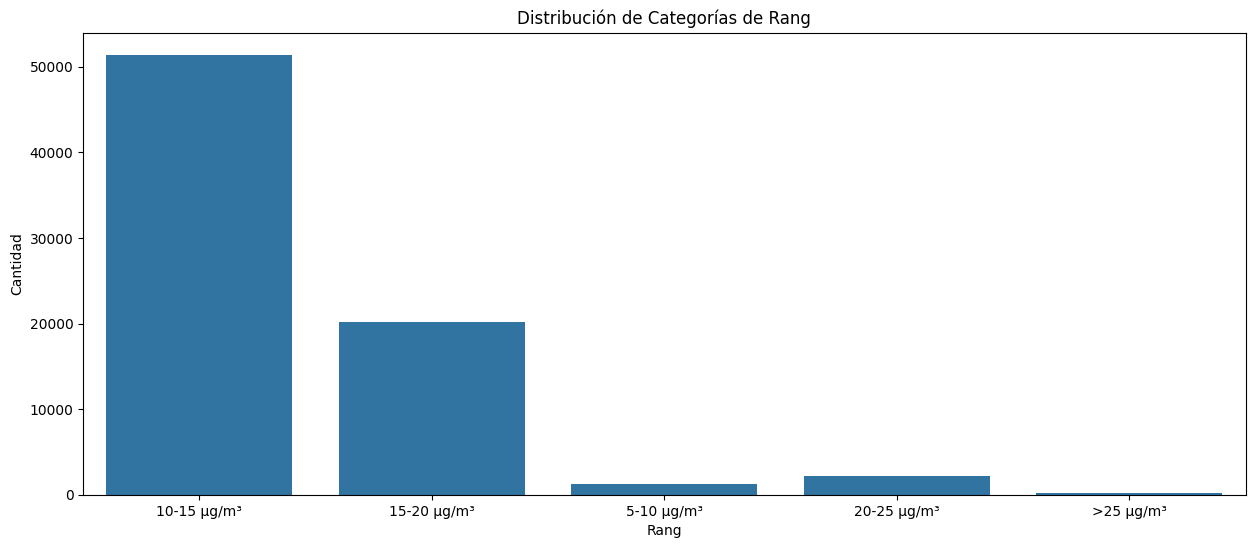

In [8]:
# Visualizamos la distribución de la variable categórica Nom_Districte utilizando un gráfico de barras
plt.figure(figsize=(15, 6))
sns.countplot(x='Rang', data=df_final)
plt.title('Distribución de Categorías de Rang')
plt.xlabel('Rang')
plt.ylabel('Cantidad')
plt.show()

### Convertir la variable categorica Rang en una variable continua

El dataset que analizamos tiene la información por tramos de calle, y el analisis que estamos realizando es a nivel de distrito. Para poder relizar una media por distrito de la concentracion de particulas finas, convertiremos la variable categorica Rang, en una variable continua. El método que seguiremos es el de codificacion de etiquetas (Label Encoding) que consiste en asignar un numero entero a cada categoria.


*   5-10 µg/m³ => 1
*   10-15 µg/m³ => 2
*   15-20 µg/m³ => 3
*   20-25 µg/m³ => 4
*   '>25 µg/m³ => 5


In [9]:
# Modificamos los valores de las categorias con diferente transcripción
df_final.loc[df_final['Rang'] == '5-10 µg/m³', 'Rang'] = 1
df_final.loc[df_final['Rang'] == '10-15 µg/m³', 'Rang'] = 2
df_final.loc[df_final['Rang'] == '15-20 µg/m³', 'Rang'] = 3
df_final.loc[df_final['Rang'] == '20-25 µg/m³', 'Rang'] = 4
df_final.loc[df_final['Rang'] == '>25 µg/m³', 'Rang'] = 5

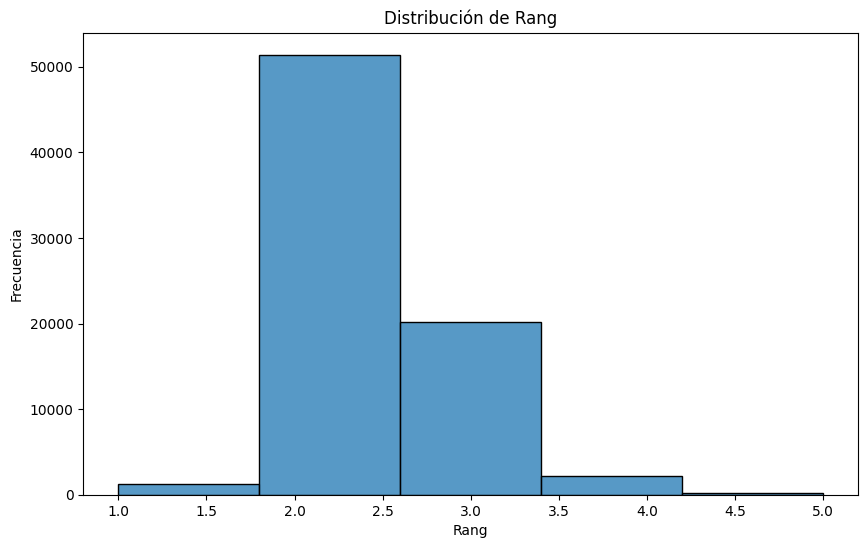

In [10]:
# Visualizamos la distribución de la principal variable numerica con un histograma
plt.figure(figsize=(10, 6))
sns.histplot(df_final['Rang'], bins=5)
plt.title('Distribución de Rang')
plt.xlabel('Rang')
plt.ylabel('Frecuencia')
plt.show()

### Agregar información de distritos de Barcelona

Para el analisis del indicador, necesitamos agregar al dataframe la información de los distritos de Barcelona.

In [11]:
# Cargar el archivo shapefile que relaciona los tramos de calles con los distritos de Barcelona
df_viales = gpd.read_file("/content/drive/MyDrive/UOC/TFM/Datasets Indicadores/Grafo viario de las calles de la ciudad de Barcelona/BCN_GrafVial_SHP/BCN_GrafVial_Trams_ETRS89_SHP.shp")

In [12]:
df_viales.head()

,COORD_X,COORD_Y,LONGITUD,ANGLE,C_Tram,C_Nus_I,C_Nus_F,Distric_D,NDistric_D,Illa_D,...,NVia_D,Tram_Dret,Distric_E,NDistric_E,Illa_E,CVia_E,TVia_E,NVia_E,Tram_Esq,geometry
0,432128.893,4581047.606,42.615,15.04,T00001B,N00001D,N00002E,01,Ciutat Vella,10390,...,Carrer Pepe Rubianes,2,01,Ciutat Vella,10410,010900,Carrer,Carrer Pepe Rubianes,1,"LINESTRING (432108.315 4581042.075, 432149.471..."
1,432156.649,4581054.946,14.806,14.20,T00002C,N00002E,N00003F,01,Ciutat Vella,10371,...,Carrer Pepe Rubianes,4 <=> 6,01,Ciutat Vella,10421,010900,Carrer,Carrer Pepe Rubianes,3 <=> 5,"LINESTRING (432149.471 4581053.136, 432163.827..."
2,432171.171,4581059.200,15.480,18.40,T00003D,N00003F,N00004G,01,Ciutat Vella,10371,...,Carrer Pepe Rubianes,4 <=> 6,01,Ciutat Vella,10421,010900,Carrer,Carrer Pepe Rubianes,3 <=> 5,"LINESTRING (432163.827 4581056.757, 432178.516..."
3,432185.863,4581063.068,14.969,10.98,T00004E,N00004G,N00005H,01,Ciutat Vella,10360,...,Carrer Pepe Rubianes,8 <=> 8 Z,01,Ciutat Vella,10441,010900,Carrer,Carrer Pepe Rubianes,7 <=> 9,"LINESTRING (432178.516 4581061.643, 432193.211..."
4,432200.396,4581066.659,15.010,16.80,T00005F,N00005H,N00006I,01,Ciutat Vella,10350,...,Carrer Pepe Rubianes,10,01,Ciutat Vella,10441,010900,Carrer,Carrer Pepe Rubianes,7 <=> 9,"LINESTRING (432193.211 4581064.493, 432207.582..."


In [13]:
# Convertimos el geodataframe a dataframe eliminando la columna geometry de los dos geodataframes
df_viales = df_viales.drop(columns='geometry')
df_final = df_final.drop(columns='geometry')

In [14]:
# Unificamos el nombre de las columnas por las que queremos realizar un merge
df_final.rename(columns={'TRAM': 'C_Tram'}, inplace=True)

In [15]:
# Unimos los dos dataframe por la columna C_Tram
merged_df = pd.merge(df_final,df_viales, on='C_Tram', how='inner')

In [16]:
merged_df.head()

,C_Tram,Rang,Any,fid,COORD_X,COORD_Y,LONGITUD,ANGLE,C_Nus_I,C_Nus_F,...,TVia_D,NVia_D,Tram_Dret,Distric_E,NDistric_E,Illa_E,CVia_E,TVia_E,NVia_E,Tram_Esq
0,T04719W,2,2022,NaN,430205.833,4586589.452,48.661,349.93,N02959E,N03005T,...,Passeig,Passeig Maragall,358 <=> 366,07,Horta-GuinardÃ³,27572,194406,Passeig,Passeig Maragall,383 - 389
1,T04719W,2,2021,NaN,430205.833,4586589.452,48.661,349.93,N02959E,N03005T,...,Passeig,Passeig Maragall,358 <=> 366,07,Horta-GuinardÃ³,27572,194406,Passeig,Passeig Maragall,383 - 389
2,T04719W,2,2020,1.0,430205.833,4586589.452,48.661,349.93,N02959E,N03005T,...,Passeig,Passeig Maragall,358 <=> 366,07,Horta-GuinardÃ³,27572,194406,Passeig,Passeig Maragall,383 - 389
3,T04719W,3,2019,NaN,430205.833,4586589.452,48.661,349.93,N02959E,N03005T,...,Passeig,Passeig Maragall,358 <=> 366,07,Horta-GuinardÃ³,27572,194406,Passeig,Passeig Maragall,383 - 389
4,T04719W,3,2018,NaN,430205.833,4586589.452,48.661,349.93,N02959E,N03005T,...,Passeig,Passeig Maragall,358 <=> 366,07,Horta-GuinardÃ³,27572,194406,Passeig,Passeig Maragall,383 - 389


In [17]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73420 entries, 0 to 73419
Data columns (total 24 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   C_Tram      73420 non-null  object 
 1   Rang        73420 non-null  object 
 2   Any         73420 non-null  object 
 3   fid         14684 non-null  float64
 4   COORD_X     73420 non-null  float64
 5   COORD_Y     73420 non-null  float64
 6   LONGITUD    73420 non-null  float64
 7   ANGLE       73420 non-null  float64
 8   C_Nus_I     73420 non-null  object 
 9   C_Nus_F     73420 non-null  object 
 10  Distric_D   73420 non-null  object 
 11  NDistric_D  73420 non-null  object 
 12  Illa_D      73420 non-null  object 
 13  CVia_D      73420 non-null  object 
 14  TVia_D      71910 non-null  object 
 15  NVia_D      71910 non-null  object 
 16  Tram_Dret   73420 non-null  object 
 17  Distric_E   73420 non-null  object 
 18  NDistric_E  73420 non-null  object 
 19  Illa_E      73420 non-nul

In [18]:
# Eliminamos las columnas que no nos interesan para el objetivo del analisis
columnas_a_eliminar = ['fid','COORD_X','COORD_Y','LONGITUD','ANGLE','C_Nus_I','C_Nus_F','Illa_D', 'CVia_D', 'TVia_D', 'NVia_D', 'Tram_Dret', 'Distric_E', 'NDistric_E', 'Illa_E', 'CVia_E', 'TVia_E', 'NVia_E', 'Tram_Esq']

merged_df= merged_df.drop(columnas_a_eliminar,axis=1)

In [19]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73420 entries, 0 to 73419
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   C_Tram      73420 non-null  object
 1   Rang        73420 non-null  object
 2   Any         73420 non-null  object
 3   Distric_D   73420 non-null  object
 4   NDistric_D  73420 non-null  object
dtypes: object(5)
memory usage: 2.8+ MB


In [20]:
# Renombrar columnas
merged_df = merged_df.rename(columns={'Rang': 'Pm25', 'Distric_D': 'Codi_Districte', 'NDistric_D': 'Nom_Districte'})

# ORden columnas
column_order = ['Any', 'Codi_Districte', 'Nom_Districte','Pm25']

# Reordenar las columnas
df_ordered = merged_df.reindex(columns=column_order)

df_ordered.head()

,Any,Codi_Districte,Nom_Districte,Pm25
0,2022,08,Nou Barris,2
1,2021,08,Nou Barris,2
2,2020,08,Nou Barris,2
3,2019,08,Nou Barris,3
4,2018,08,Nou Barris,3


In [21]:
# Agrupamos los datos por Any, Mes, Codi_Districte, Nom_Districte
df_PM25Agrup = df_ordered.groupby(['Any','Codi_Districte','Nom_Districte'])

# Sumamos las variables continuas ParadosReg y NoParados
df_PM25Agrup=df_PM25Agrup[['Pm25']].mean()

df_PM25Agrup.head()

Pm25
Any  Codi_Districte Nom_Districte                 
2018 01             Ciutat Vella          2.282272
     02             Eixample              2.990421
     03             Sants-MontjuÃ¯c       2.213685
     04             Les Corts             2.459279
     05             SarriÃ -Sant Gervasi  2.327853

In [22]:
# Reseteamos indices sobre el dataframe agrupado
df_PM25Agrup = df_PM25Agrup.reset_index()

## Creación de .csv

Obtenemos el archivo datosParo.csv con los datos del dataframe resultante

In [23]:
# Guardar el DataFrame en un archivo CSV
df_PM25Agrup.to_csv('datosPM25.csv', index=False)

## Análisis Exploratorio de Datos (EDA)

Una vez tenemos los datos limpios continuamos con la exploracion inicial de los datos

### Variable continua Concentracion de particulas finas (Pm25)

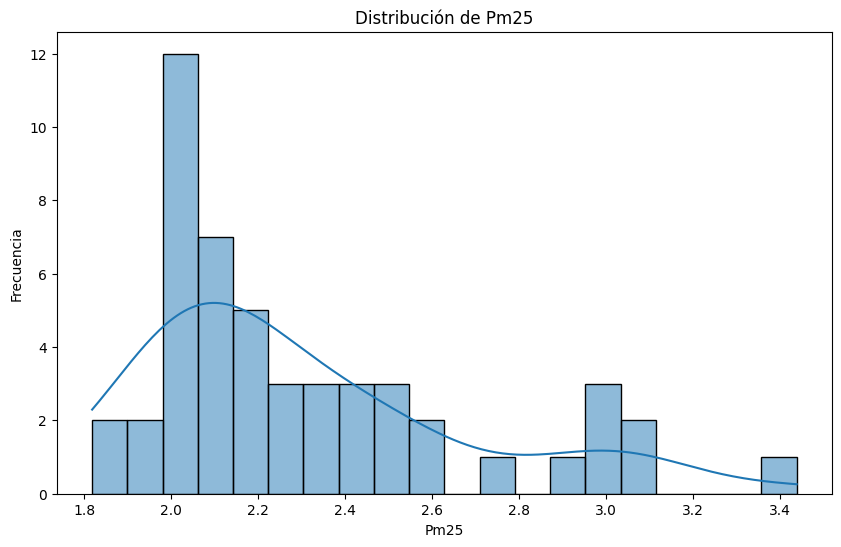

In [24]:
# Visualizamos la distribución de la principal variable numerica con un histograma
plt.figure(figsize=(10, 6))
sns.histplot(df_PM25Agrup['Pm25'], bins=20, kde=True)
plt.title('Distribución de Pm25')
plt.xlabel('Pm25')
plt.ylabel('Frecuencia')
plt.show()

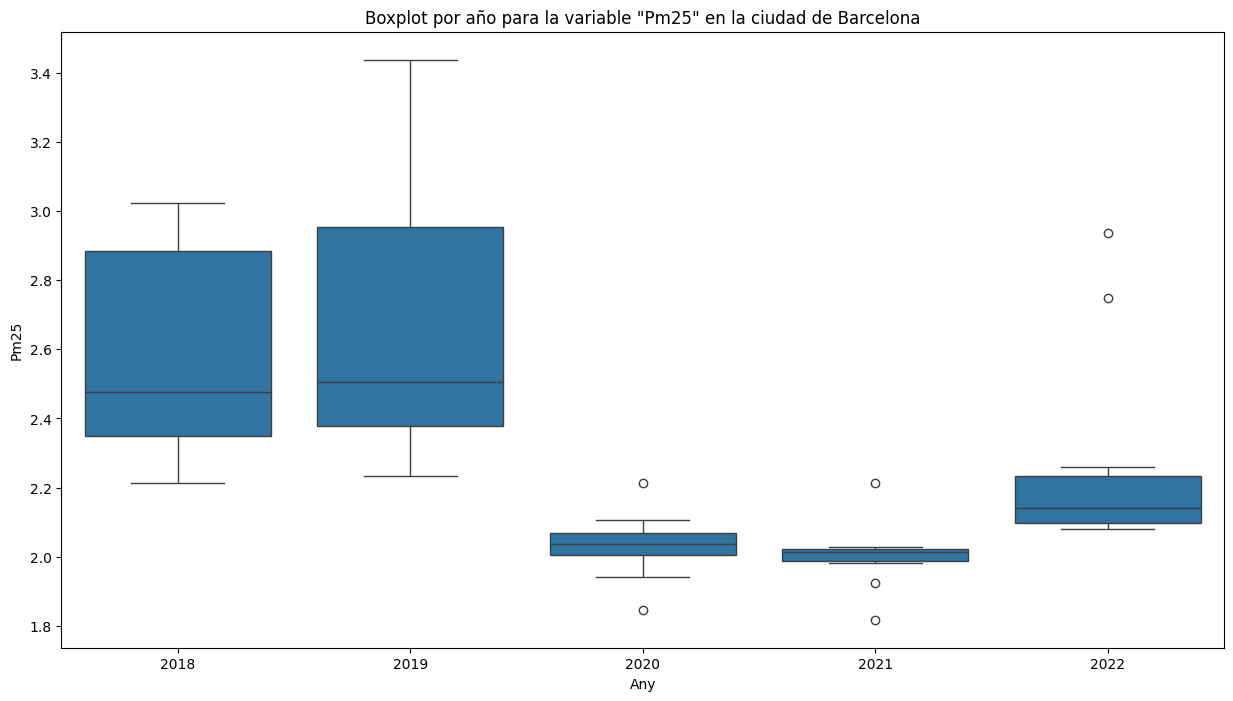

In [25]:
# Crear diagrama de caja para la variable continua "Pm25" en funcion de la variable categorica "Any"
plt.figure(figsize=(15, 8))
sns.boxplot(x='Any', y='Pm25', data=df_PM25Agrup)
plt.title('Boxplot por año para la variable "Pm25" en la ciudad de Barcelona')

# Mostrar el diagrama de caja
plt.show()

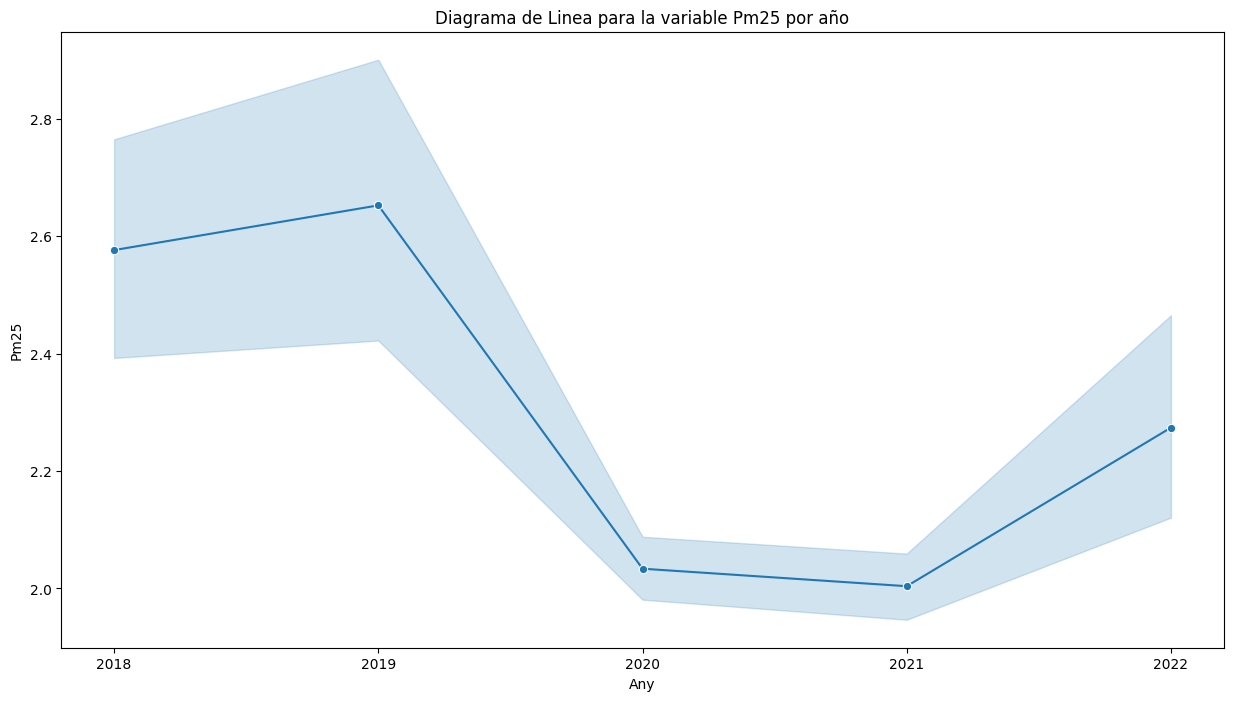

In [26]:
# Creamos un diagrama de linea
plt.figure(figsize=(15, 8))
sns.lineplot(data=df_PM25Agrup, x='Any', y='Pm25', marker='o')# Graficar los valores de la variable continua
plt.title('Diagrama de Linea para la variable Pm25 por año')
plt.xlabel('Any')
plt.ylabel('Pm25')

plt.show()

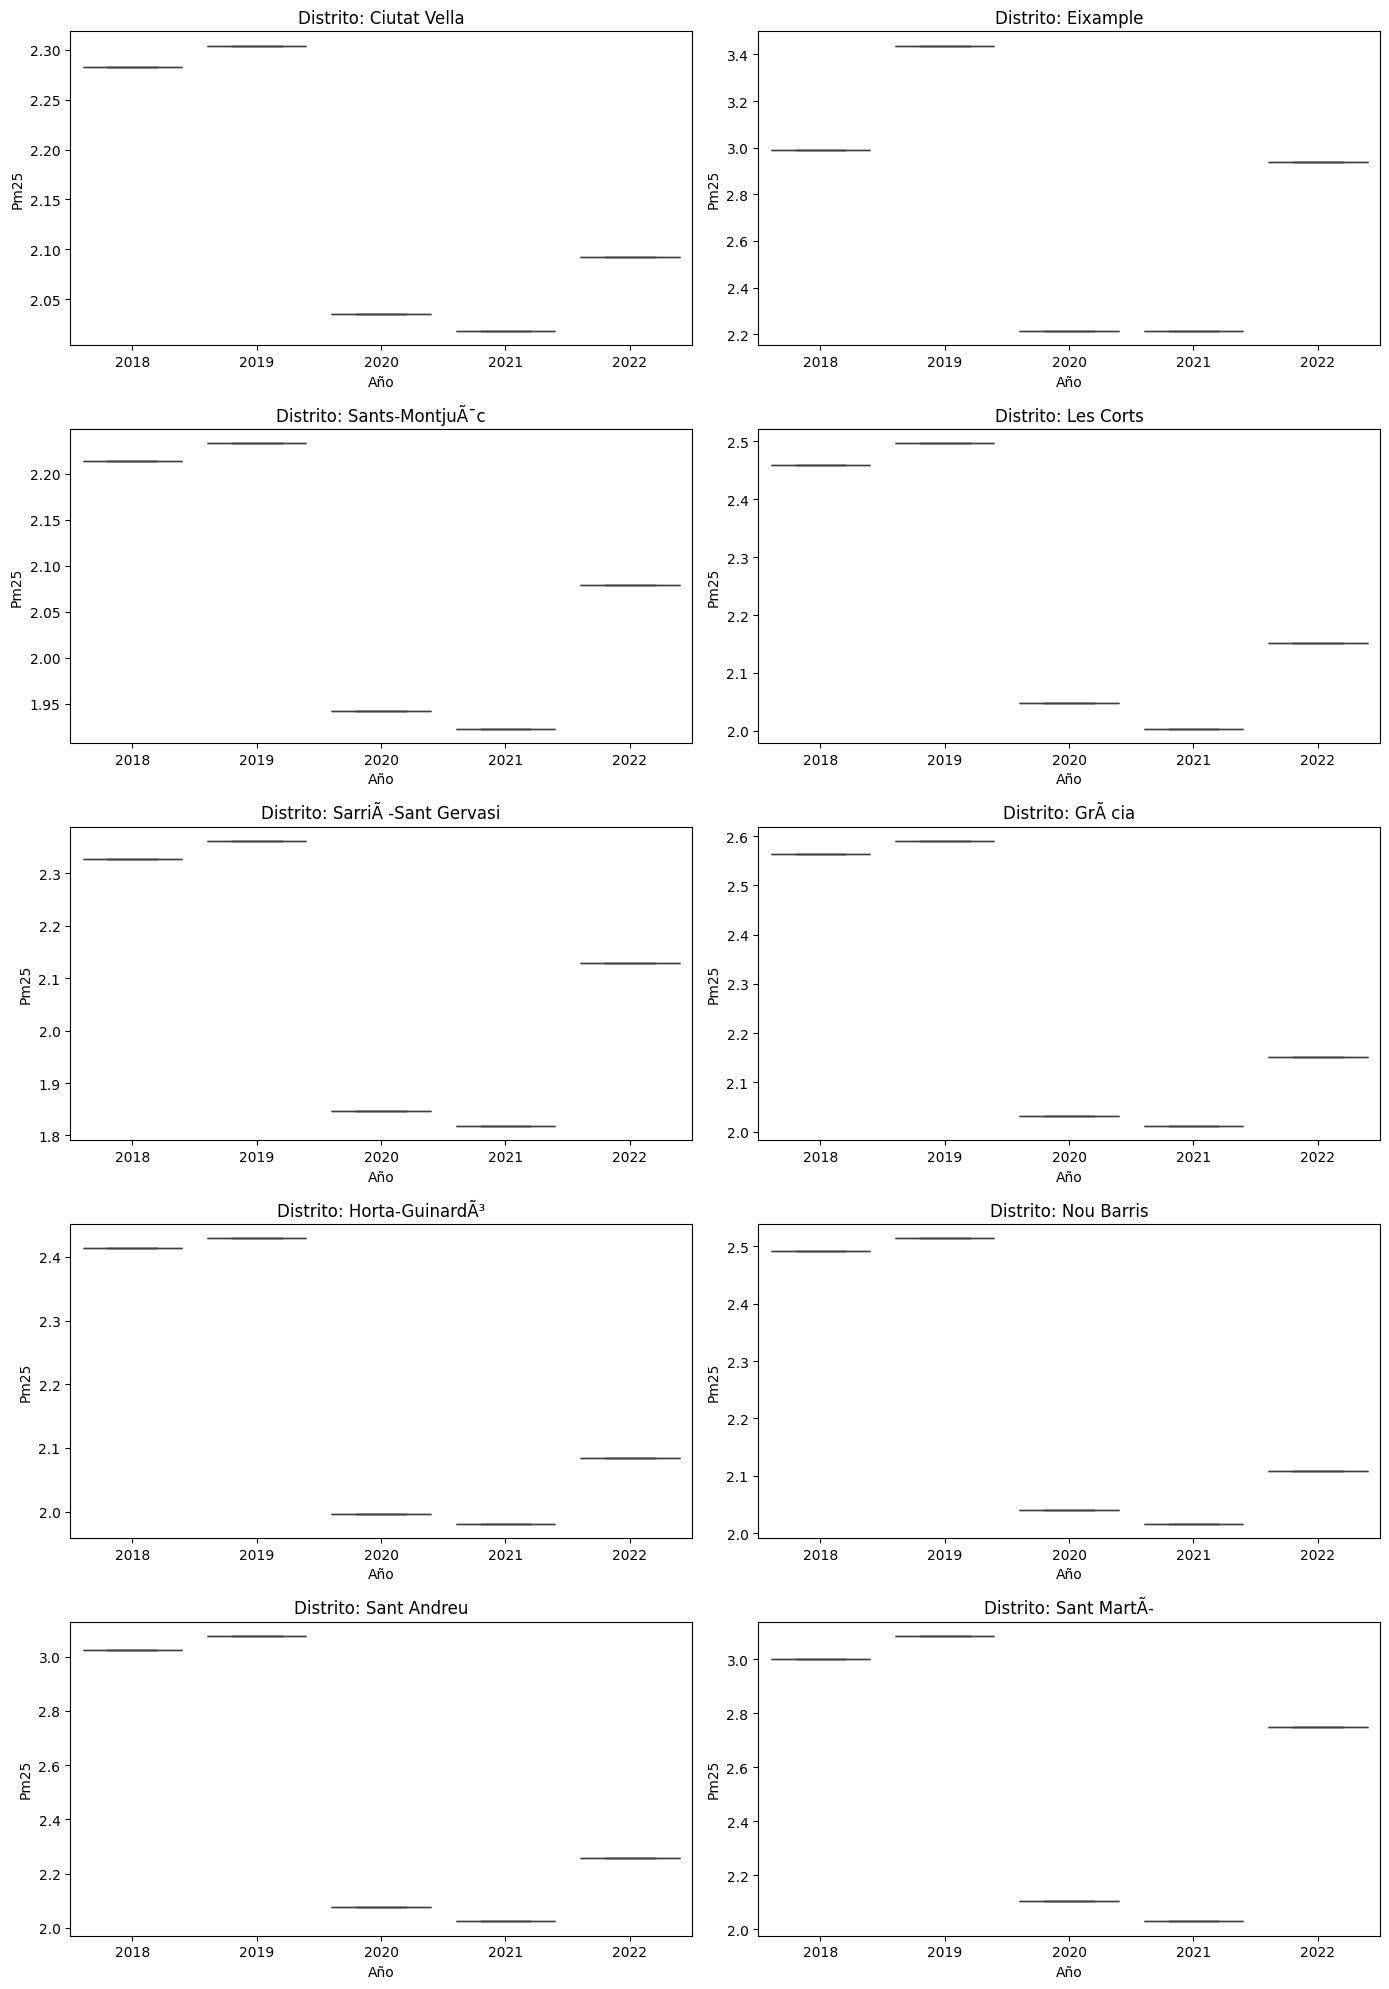

In [27]:
# Crear varios gráficos de boxplot en el mismo eje
plt.figure(figsize=(14,20))

# Primero, dividir los datos por las categorías de la primera variable categórica
for i, category in enumerate(df_PM25Agrup['Nom_Districte'].unique(), start=1):
    plt.subplot(5, 2, i)
    subset = df_PM25Agrup[df_PM25Agrup['Nom_Districte'] == category]

    # Crear un boxplot para cada subconjunto de datos
    sns.boxplot(x='Any', y='Pm25', data=subset, ax=plt.gca())
    plt.title(f'Distrito: {category}')
    plt.xlabel('Año')
    plt.ylabel('Pm25')

plt.tight_layout()
plt.show()

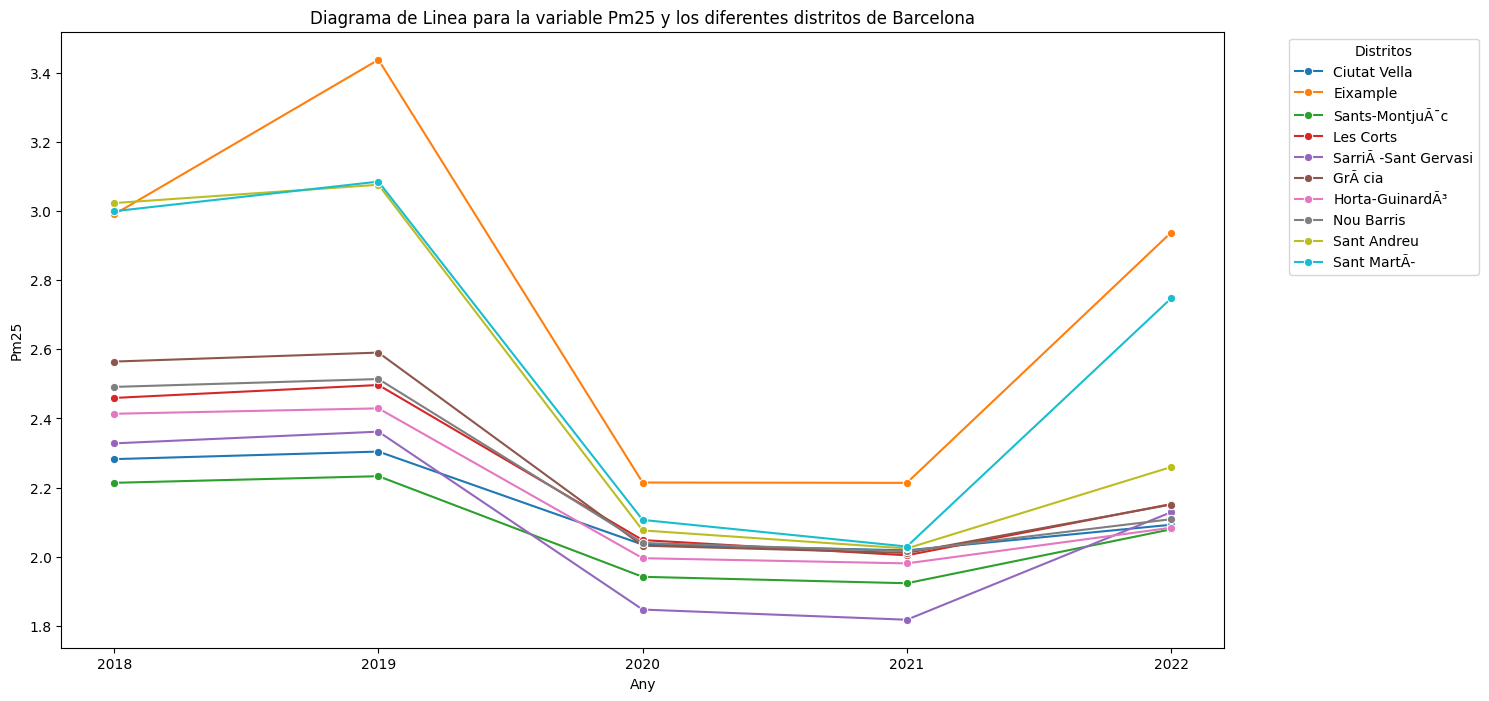

In [28]:
# Creamos un diagrama de linea
plt.figure(figsize=(15, 8))


sns.lineplot(data=df_PM25Agrup, x='Any', y='Pm25', hue='Nom_Districte', marker='o')# Graficar los valores de la variable continua
plt.title('Diagrama de Linea para la variable Pm25 y los diferentes distritos de Barcelona')
plt.xlabel('Any')
plt.ylabel('Pm25')
plt.legend(title='Distritos', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(df_PM25Agrup['Any'].unique())

# Sacamos la leyenda fuera del grafico

plt.show()

## Carga del Shapefile

Cargamos el archivo tipo shape con los 10 distritos de Barcelona

In [29]:
# Cargar el archivo shapefile de los distritos de Barcelona
barcelona_distritos = gpd.read_file("/content/drive/MyDrive/UOC/TFM/Datasets Indicadores/Grafo viario de las calles de la ciudad de Barcelona/BCN_UNITATS_ADM/0301040100_Districtes_UNITATS_ADM.shp")

# Mostrar información básica sobre el shapefile
barcelona_distritos.head()


,ID_ANNEX,ANNEXDESCR,ID_TEMA,TEMA_DESCR,ID_CONJUNT,CONJ_DESCR,ID_SUBCONJ,SCONJ_DESC,ID_ELEMENT,ELEM_DESCR,...,ESTIL_ID_V,ESTIL_QGIS,VALOR1QGIS,VALOR2QGIS,COL_FARCIT,FCOL_DESCR,FHEX_COLOR,COL_DESCR,HEX_COLOR7,geometry
0,01,Grup - I,0104,Unitats Administratives,010412,Districtes,01041201,Districte,0104120101,LÃ­mit de districte,...,0,SÃ²lid,0,0,1,Negre,#000000,Negre,#000000,"POLYGON ((431733.736 4582441.816, 431827.673 4..."
1,01,Grup - I,0104,Unitats Administratives,010412,Districtes,01041201,Districte,0104120101,LÃ­mit de districte,...,0,SÃ²lid,0,0,1,Negre,#000000,Negre,#000000,"POLYGON ((432033.184 4583665.032, 432032.069 4..."
2,01,Grup - I,0104,Unitats Administratives,010412,Districtes,01041201,Districte,0104120101,LÃ­mit de districte,...,0,SÃ²lid,0,0,1,Negre,#000000,Negre,#000000,"MULTIPOLYGON (((428773.911 4580873.742, 428833..."
3,01,Grup - I,0104,Unitats Administratives,010412,Districtes,01041201,Districte,0104120101,LÃ­mit de districte,...,0,SÃ²lid,0,0,1,Negre,#000000,Negre,#000000,"POLYGON ((425054.670 4583672.560, 425062.830 4..."
4,01,Grup - I,0104,Unitats Administratives,010412,Districtes,01041201,Districte,0104120101,LÃ­mit de districte,...,0,SÃ²lid,0,0,1,Negre,#000000,Negre,#000000,"MULTIPOLYGON (((422563.071 4587486.743, 422568..."


In [30]:
# Convertimos el tipo de valor de la variable distrito a entero
barcelona_distritos['DISTRICTE'] = barcelona_distritos['DISTRICTE'].astype(int)
df_PM25Agrup['Codi_Districte'] = df_PM25Agrup['Codi_Districte'].astype(int)

In [31]:
# Mostramos la nomenclatura para los graficos posteriores
print (df_PM25Agrup[['Codi_Districte', 'Nom_Districte']].drop_duplicates().to_string(index=False))

 Codi_Districte        Nom_Districte
              1         Ciutat Vella
              2             Eixample
              3      Sants-MontjuÃ¯c
              4            Les Corts
              5 SarriÃ -Sant Gervasi
              6              GrÃ cia
              7      Horta-GuinardÃ³
              8           Nou Barris
              9          Sant Andreu
             10          Sant MartÃ­


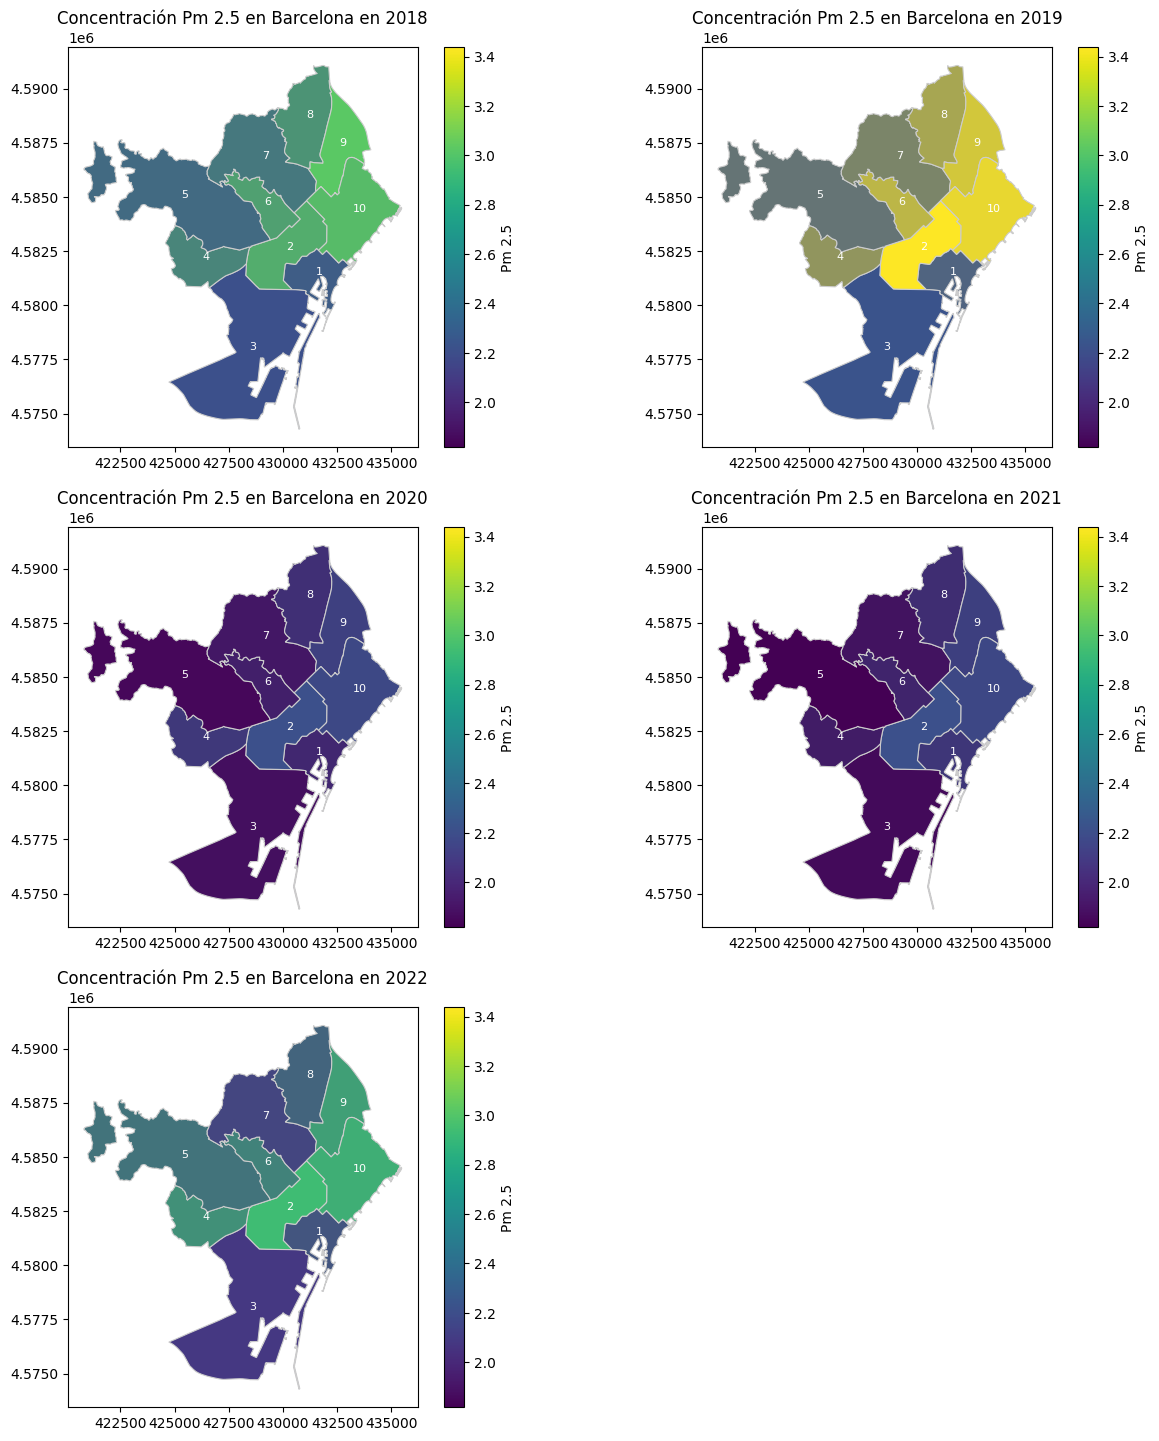

In [34]:
# Suprimir todas las advertencias
warnings.filterwarnings("ignore")

plt.figure(figsize=(15, 80))

# Definir el valor máximo y mínimo global de contaminación
max_contaminacion_global = df_PM25Agrup['Pm25'].max()
min_contaminacion_global = df_PM25Agrup['Pm25'].min()

# Crear un colormap Viridis basado en el rango global de valores de contaminación
viridis_cmap = viridis

# Iterar sobre cada año para crear un gráfico para cada uno
for i, year in enumerate(df_PM25Agrup['Any'].unique(), start=1):

    plt.subplot(13, 2, i)
    # Filtrar los datos para el año actual
    datos_year = df_PM25Agrup[df_PM25Agrup['Any'] == year]

    # Calcular el valor máximo y mínimo de contaminación para este año
    max_contaminacion_year = datos_year['Pm25'].max()
    min_contaminacion_year = datos_year['Pm25'].min()

    # Normalizar los valores de contaminación de este año con respecto al rango global
    norm_year = lambda x: (x - min_contaminacion_global) / (max_contaminacion_global - min_contaminacion_global)
    #datos_year['Color'] = datos_year['Pm10'].apply(norm_year)

    datos_year.loc[datos_year['Any'] == year, 'Color'] = datos_year.loc[datos_year['Any'] == year, 'Pm25'].apply(norm_year)

    # Crear un nuevo colormap linealizado para este año basado en el colormap Viridis
    custom_cmap = LinearSegmentedColormap.from_list("custom_viridis",
                                                     [viridis_cmap(norm_year(min_contaminacion_year)),
                                                      viridis_cmap(norm_year(max_contaminacion_year))])

    # Combinar los datos con el shapefile
    distritos_year = barcelona_distritos.merge(datos_year, how='left', left_on='DISTRICTE', right_on='Codi_Districte') # Combinar datos CSV y Shapefile


    # Añadir los nombres de los distritos
    for idx, row in barcelona_distritos.iterrows():
        plt.text(row.geometry.centroid.x, row.geometry.centroid.y, row['DISTRICTE'], fontsize=8,color='white')

    # Crear el mapa de los distritos de Barcelona en el año actual con colores representando la contaminación
    plt.title(f"Concentración Pm 2.5 en Barcelona en {year}")

    distritos_year.plot(ax=plt.gca(),column='Pm25', cmap=custom_cmap, linewidth=0.8, edgecolor='0.8', legend=False)

    # Añadir una barra de color para mostrar la escala
    sm = plt.cm.ScalarMappable(cmap=viridis_cmap, norm=plt.Normalize(vmin=min_contaminacion_global, vmax=max_contaminacion_global))
    sm._A = []
    # Crear la leyenda con un gradiente de color
    cbar = plt.colorbar(sm, ax=plt.gca())
    cbar.set_label('Pm 2.5')  # Establece el nombre de la variable

